Add imports

In [20]:
import random
import torch
import math
from datasets import load_dataset
import sentencepiece as spm
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import os

Set hyperparameters

In [21]:

embedding_size = 7
hidden_layer_size = 11
batch_size = 60
num_epochs = 20
vocab_size = 8000
max_sequence_length = 4123

torch.manual_seed(42)

Load the dataset and train sentencepiece on it

In [22]:
# if not os.path.exists("sentences.txt"):
dataset = load_dataset("roneneldan/TinyStories")

sample_data = dataset["train"]['text'][:3000]

max_sequence_length = max(len(sentence) for sentence in sample_data)
print(max_sequence_length)

with open('sentences.txt', 'w') as f:
    for sentence in sample_data:
        if sentence.strip():  # Check if the stripped sentence is not empty
            f.write(sentence)  # Write the sentence to the file with a newline

with open("sentences.txt", "r") as f:
    lines = f.readlines()

lines = [line for line in lines if line.strip()]

with open("sentences.txt", "w") as f:
    f.writelines(lines)
input_file = 'sentences.txt' 
prefix = 'sentences'
vocab_size = 750

spm.SentencePieceTrainer.train(
    input=input_file, 
    model_prefix=prefix, 
    vocab_size=vocab_size
)

Repo card metadata block was not found. Setting CardData to empty.


4123


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: sentences.txt
  input_format: 
  model_prefix: sentences
  model_type: UNIGRAM
  vocab_size: 750
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level:

In [23]:
#define and initialise the sentencepiece tokenizer
class SentencePieceTokenizer:
    def __init__(self, model_path):
        self.tokenizer = spm.SentencePieceProcessor(model_file=model_path)

    def encode(self, text):
        return self.tokenizer.encode(text, out_type=int)
    
    def decode(self, tokens):
        return self.tokenizer.decode_pieces(tokens)

model_path = "sentences.model"
sentence_piece_tokenizer = SentencePieceTokenizer(model_path)

foo = sentence_piece_tokenizer.encode('john') # [68, 27, 5]
bar = sentence_piece_tokenizer.decode(foo)    # john


In [24]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self):
    f = open('sentences.txt', 'r')
    self.stories = f.read().split('\n')
    f.close()

  def __len__(self):
    return len(self.stories)

  def __getitem__(self, idx):
    story = self.stories[idx]
    return torch.tensor(sentence_piece_tokenizer.encode(story))
  
def collate_fn(batch):
    # Sort batch by sequence length (descending order)
    batch = sorted(batch, key=lambda x: len(x), reverse=True)
    # Pad sequences to the same length
    padded_sequences = pad_sequence(batch, batch_first=True, padding_value=0)
    return padded_sequences


ds = Dataset()
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


Create the simple transformer

In [25]:
class BesSimpleTransformer(torch.nn.Module):
  def __init__(self):
    super(BesSimpleTransformer, self).__init__()
    # Embedding part of the model
    self.embedding    = torch.nn.Embedding(vocab_size, embedding_size)
    self.pos_emb      = self.get_pos_matrix()
    # Mask tensor trick
    self.register_buffer('mask', torch.tril(torch.ones(max_sequence_length, max_sequence_length)))
    # First decoder block 
    self.layer_00_key = torch.nn.Linear(embedding_size, hidden_layer_size)
    self.layer_00_qry = torch.nn.Linear(embedding_size, hidden_layer_size)
    self.layer_00_val = torch.nn.Linear(embedding_size, hidden_layer_size)
    self.layer_00_ffw = torch.nn.Linear(hidden_layer_size, embedding_size)
    # Second decoder block
    self.layer_01_key = torch.nn.Linear(embedding_size, hidden_layer_size)
    self.layer_01_qry = torch.nn.Linear(embedding_size, hidden_layer_size)
    self.layer_01_val = torch.nn.Linear(embedding_size, hidden_layer_size)
    self.layer_01_ffw = torch.nn.Linear(hidden_layer_size, embedding_size)
    # Output of the model
    self.map_to_vocab = torch.nn.Linear(embedding_size, vocab_size)

  def forward(self, x):
    emb = self.embedding(x) #embedding_size -> here supposedly 761?? why
    pos = self.pos_emb[0:x.shape[0], :]
    emb = emb + pos

    key = self.layer_00_key(emb)
    qry = self.layer_00_qry(emb)
    val = self.layer_00_val(emb)
    att = torch.mm(qry, key.t())
    msk = self.mask[0:x.shape[0], 0:x.shape[0]]
    att = att.masked_fill(msk == 0, float('-inf'))
    att = torch.nn.functional.softmax(att, dim=1)
    res = torch.mm(att, val)
    res = self.layer_00_ffw(res)

    key = self.layer_01_key(res)
    qry = self.layer_01_qry(res)
    val = self.layer_01_val(res)
    att = torch.mm(qry, key.t())
    msk = self.mask[0:x.shape[0], 0:x.shape[0]]
    att = att.masked_fill(msk == 0, float('-inf'))
    att = torch.nn.functional.softmax(att, dim=1)
    res = torch.mm(att, val)
    res = self.layer_01_ffw(res)

    out = self.map_to_vocab(res)
    return out

  def get_pos_matrix(self):
    store = torch.zeros(max_sequence_length, embedding_size)
    for pos in range(max_sequence_length):
      for i in range(0, embedding_size, 2):
        denominator = 10000 ** (2 * i / embedding_size)
        store[pos, i] = math.sin(pos / denominator)
        if i + 1 < embedding_size: store[pos, i + 1] = math.cos(pos / denominator)
    return store


Initialise and train the transformer

In [26]:
m = BesSimpleTransformer()
opt = torch.optim.SGD(m.parameters(), lr=0.01)

losses = []
for epoch in range(num_epochs):
  for idx, batch in enumerate(dl):
    
    sos = torch.tensor([2])
    eos = torch.tensor([1])

    x = batch[0]
    x = torch.cat([sos, x])
    y = torch.cat([x[1:], eos])

    p = m(x)
    l = torch.nn.functional.cross_entropy(p, y)
    if idx % 1000 == 0: 
      print("Loss:", l.item())
      losses.append(l.item())
    l.backward()
    opt.step()
    opt.zero_grad()

  

Loss: 6.628210544586182
Loss: 6.565324306488037
Loss: 6.505987167358398
Loss: 6.425851821899414
Loss: 6.298823356628418
Loss: 6.116059303283691
Loss: 5.9751176834106445
Loss: 5.880334377288818
Loss: 5.808562755584717
Loss: 5.751628398895264
Loss: 5.706038475036621
Loss: 5.669605255126953
Loss: 5.640267848968506
Loss: 5.616209506988525
Loss: 5.596062660217285
Loss: 5.578853130340576
Loss: 5.5638837814331055
Loss: 5.550646781921387
Loss: 5.538785934448242
Loss: 5.528066158294678


Map the losses to see how well the training has gone

5.528066158294678


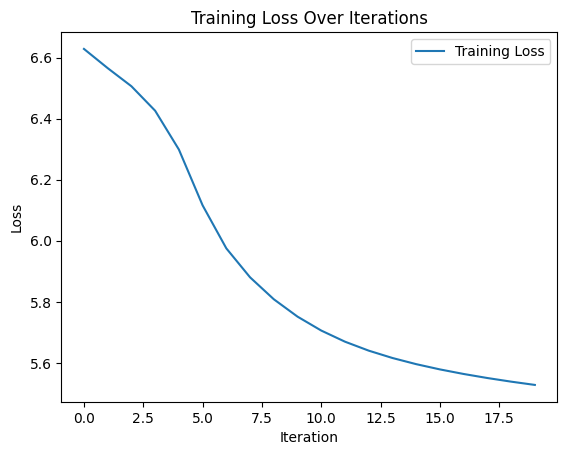

In [27]:
print(losses[-1])

# Plot the losses
plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.show()

Define different sampling strategies (how do you choose the next token)

In [28]:
#define different sampling approaches to test out
def greedy_decode(next_token_options, x):
  next_token = torch.argmax(next_token_options) # find index of maximum value in each row 
  x = torch.cat([x, next_token.unsqueeze(0)]) #here we're just adding the last, converted to 2D
  return x

def random_sample(next_token_options, x):
  next_token = torch.multinomial(next_token_options, 1)  # Sample the next token using a multinomial distribution
  x = torch.cat([x, next_token])  # Add the sampled token to the sequence
  return x

def top_k_sample(next_token_options, x, k=30):
  top_k_values, top_k_indices = torch.topk(next_token_options, k)  # Get the top-k values and indices
  print("choose from:", sentence_piece_tokenizer.decode(top_k_indices.tolist()))
  # next_token = top_k_indices[:, torch.randint(k, (1,))]  # Randomly select from the top-k tokens
  next_token = top_k_indices[torch.randint(k, (1,))]
  x = torch.cat([x, next_token])  # Add the selected token to the sequence
  return x

Generate some text from a random start token

In [29]:
random_start_token = random.randint(3, vocab_size)
x = sentence_piece_tokenizer.decode([random_start_token])
x = torch.cat([sos, torch.tensor(sentence_piece_tokenizer.encode(x))])
print("find next token after:", sentence_piece_tokenizer.decode(x.tolist()))
while True:
  p = m(x) #logits 
  p = torch.nn.functional.softmax(p, dim=1) #convert logits to likelihood out of 1
  next_token_options = p[-1]
  x = top_k_sample(next_token_options, x)
  if x[-1] == 1 or len(p.tolist()) == 20: break #stop generating if last token is end token or sequence len is 17
print("Generate:", sentence_piece_tokenizer.decode(x.tolist()))

find next token after: might
choose from: . and the,  as tote wasdaedyo Theymri it her he Heoner Sheplu
choose from: . and the, as  tote wasdayedo Theymri it He her heonpler Sheu
choose from: . and the,s a  tote wasdayedo Theymri it He her heonl Sheperu
choose from: . and the,s a  tote wasdayedo Theymri it He her heonlp Sheeru
choose from: . and the,s a  tote wasdayedo Theymri it He her heonl Sheperu
choose from: . and the,s a  tote wasdayedo Theymri it He her heonlp Sheuer
choose from: . and the,s a  tote wasdayedo Theymri He it her heonlp Sheuer
choose from: . and the,s a  tote wasdyaoed Theymri He it her helonp She hisu
choose from: . and the,s a  tote wasdyaedo Theymri He it her helonp She hisu
choose from: . and the,s a  tote wasdayedo Theymri it He her heonlpu Sheer
choose from: . and the,s a  tote wasdayedo Theymri it He he heronlpuer She
choose from: . and the,s a  tote wasdayedo Theymri it He he heronlpu Sheer
choose from: . and the,s a  tote wasdayedom Theyri it He he heronlp